In [1]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import Row
import pyarrow.parquet as pq
import pyarrow as pa
import os

from homepage2vec.model import WebsiteClassifier



os.environ['SPARK_HOME'] = "/home/veselovs/spark-3.2.1-bin-hadoop2.7"
os.environ['JAVA_HOME'] = "/home/veselovs/jdk-13.0.2"
spark = SparkSession.builder.getOrCreate()


/home/veselovs/miniconda3/lib/python3.9/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(
2022-10-11 15:38:38.484898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 15:38:38.484961: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
22/10/11 15:39:07 WARN Utils: Your hostname, iccluster039 resolves to a loopback address: 127.0.1.1; using 10.90.38.15 instead (on interface ens786f0)
22/10/11 15:39:07 WARN Utils: Set SPARK_LOCAL_IP if you need

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import OrderedDict
sns.set_style("whitegrid", {'axes.grid' : False})

@F.udf 
def reverse_reverse_host(x):
    x = x.split(".")
    x = x[-1::-1]
    x = ".".join(x)
    return x


In [34]:
common_crawl = spark.read.parquet("/scratch/venia/web2wiki/data/common_crawl_random_sample.parquet")


In [37]:
common_crawl.filter(F.col("_c2").cast(IntegerType())<100000).take(3)

[Row(_c0='298519', _c1='1.6389827E7', _c2='21214', _c3='2.016271248704441E-6', _c4='uk.co.gettyimages', _c5='3'),
 Row(_c0='10044110', _c1='1.3737157E7', _c2='40501', _c3='9.280135646373462E-7', _c4='com.down', _c5='3'),
 Row(_c0='7013', _c1='1.8014366E7', _c2='3944', _c3='9.355278271622294E-6', _c4='gov.ahrq', _c5='89')]

In [ ]:
common_crawl = common_crawl.withColumn("domain", reverse_reverse_host("_c4"))
common_crawl = common_crawl.select("*").orderBy(F.rand())
sample = common_crawl.sample(0.01)
sample = sample.filter(F.col("domain").rlike("\.com|\.ca|\.co\.uk|\.org"))
sample = sample.select("domain").toPandas()

In [6]:
df = spark.read.load("/scratch/venia/web2wiki/data/merged_metadata.parquet")

In [7]:
df = df.select("*").orderBy(F.rand())
df = df.dropDuplicates(subset=["domain"]).select("domain")
wiki_sample = df.sample(0.05)
wiki_sample = wiki_sample.toPandas()

In [18]:


wiki_sample.head(50000).to_csv("/scratch/venia/web2wiki/data/homepage2vec/wiki_sample.csv",index=False)

sample.head(50000).to_csv("/scratch/venia/web2wiki/data/homepage2vec/common_crawl_sample.csv",index=False)




In [3]:
wiki_sample = pd.read_csv("/scratch/venia/web2wiki/data/homepage2vec/wiki_sample.csv")

sample = pd.read_csv("/scratch/venia/web2wiki/data/homepage2vec/common_crawl_sample.csv")


In [4]:
ws = wiki_sample.head(10000)
cs = sample.head(10000)

In [5]:
model = WebsiteClassifier(cpu_threads_count=20, dataloader_workers=20)


In [7]:
def get_scores(domain):
    try:
        website = model.fetch_website(domain)
        scores, embeddings = model.predict(website)
    except:
        scores = None
    return (domain,scores)


def process_samples(df):
    scores_list = []
    for i, value in df.iterrows():
        domain = value["domain"]
        scores_list.append(get_scores(domain))
    return scores_list
        

In [29]:
import time
t = time.time()
vals = process_samples(cs.sample(100))
print(time.time()- t)

149.29002571105957


In [ ]:
print("Starting")
sample_wiki = process_samples(ws)
print("ONTO THE WEB")
sample_web = process_samples(cs)

Starting


/home/veselovs/miniconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:621: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


In [10]:
wiki_scores = pd.DataFrame(sample_wiki)
sample_web = pd.DataFrame(sample_web)

In [12]:
wiki_scores.to_csv("/scratch/venia/web2wiki/data/homepage2vec/10k_wiki.csv",index=False)
sample_web.to_csv("/scratch/venia/web2wiki/data/homepage2vec/10k_web.csv",index=False)


In [64]:
wiki_scores = pd.read_csv("/scratch/venia/web2wiki/data/homepage2vec/10k_wiki.csv")
sample_web = pd.read_csv("/scratch/venia/web2wiki/data/homepage2vec/10k_web.csv")

In [66]:
wiki_scores = wiki_scores.dropna()

In [67]:
sample_web = sample_web.dropna()

In [68]:
wiki_scores.index = wiki_scores["0"]
sample_web.index = sample_web["0"]

In [74]:
wiki_scores["1"] = wiki_scores["1"].apply(eval)
sample_web["1"] = sample_web["1"].apply(eval)

wss = wiki_scores["1"].apply(pd.Series)
sws = sample_web["1"].apply(pd.Series)

/tmp/ipykernel_982453/4049378097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wiki_scores["1"] = wiki_scores["1"].apply(eval)


In [76]:
wiki_mean = wss.mean()

In [77]:
web_mean = sws.mean()

In [78]:
wiki_mean.index = [k.replace("_", " ") for k in wiki_mean.index]
web_mean.index = [k.replace("_", " ") for k in web_mean.index]

In [79]:
vals = (wiki_mean-web_mean).sort_values(ascending=False)

In [132]:
wiki_mean = wiki_mean.sort_values()

In [136]:
vals = vals.abs().sort_values()

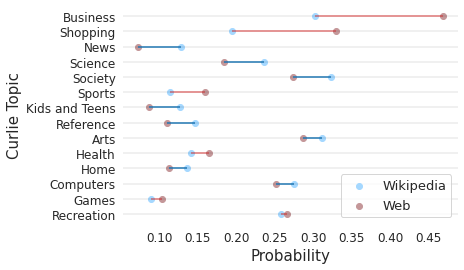

In [145]:
fig,ax=plt.subplots()
for i,val in zip(vals.index, vals):
    val1 = wiki_mean[wiki_mean.index==i].values[0]
    val2 = web_mean[web_mean.index==i].values[0]
    plt.axhline(i, 0,1,alpha = 0.4, linewidth = 0.3, color = "k")

    x1 = min([val1,val2])
    x2 = max([val1,val2])
    
    if val1 > val2:
        plt.hlines(i,xmin = x1,xmax =x2)
    else:
        plt.hlines(i,xmin = x1,xmax =x2, color = "tab:red", alpha = 0.6)
    
plt.scatter(wiki_mean.values,wiki_mean.index,label = "Wikipedia", color = "#A5D8FF")
plt.scatter(web_mean.values,web_mean.index, label = "Web", color = "#C49799")

plt.tick_params(labelsize = 12)
plt.legend(frameon = True, loc = "lower right", fontsize = 13)
plt.xlabel("Probability", fontsize = 15)
plt.ylabel("Curlie Topic", fontsize = 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# plt.savefig("/scratch/venia/web2wiki/visuals/where_shared.pdf",dpi = 300, bbox_inches="tight")

In [26]:
df = pd.read_parquet("/scratch/venia/web2wiki/data/merged_metadata.parquet")

In [27]:
domain_counts = df.groupby("domain")["count"].sum()

In [28]:
domain_counts.sort_values(ascending=False).head(10)

domain
blogspot.com        1269850
wordpress.com       1223110
portalfield.com      524458
wikimedia.org        415872
pungenerator.org     298216
coinshome.net        253809
wikitrans.net        253700
fandom.com           235903
dbpedia.org          195229
appspot.com          191901
Name: count, dtype: int64

In [31]:
print("Percentage More than 100:", len(domain_counts[domain_counts>100]) / len(domain_counts), "Num more than 1:", len(domain_counts[domain_counts>100]))

Percentage More than 100: 0.0319917674862661 Num more than 1: 40881


In [8]:
urls = spark.read.load("/scratch/venia/web2wiki/data/en_wikilinks_url.parquet/")

In [11]:
urls.groupBy("url").count().write.parquet("/scratch/venia/web2wiki/data/en_url_counts.parquet/")

In [6]:
urls = urls.filter(F.col("wikidb") == "en")
url_counts = urls.groupBy("url", "title").count()

In [7]:
url_counts.write.parquet("/scratch/venia/web2wiki/data/en_wikilinks_url.parquet")

In [12]:
urls = pd.read_parquet("/scratch/venia/web2wiki/data/en_wikilinks_url.parquet/")

In [14]:
urls["is_wiki"] = urls["url"].apply(lambda x: 1 if "wiki" in x or "pedia" in x else 0)


In [16]:
import re
pattern = re.compile(r"[12][90][89012][0123456789]/[01]\d")
urls["is_blog"] = urls["url"].apply(lambda x: 1 if "blog" in x or bool(pattern.search(x)) else 0)
    

In [19]:
print("Percentage Wiki:", urls["is_wiki"].sum() / len(urls), "Num Wiki:", urls["is_wiki"].sum())

Percentage Wiki: 0.111103633859358 Num Wiki: 4444458


In [20]:
print("Percentage Blog:", urls["is_blog"].sum() / len(urls), "Num Blog:", urls["is_blog"].sum())

Percentage Blog: 0.2946180986167623 Num Blog: 11785553


In [24]:
print("Percentage More than 1:", len(urls[urls["count"]>1]) / len(urls), "Num more than 1:", len(urls[urls["count"]>1]))

Percentage More than 1: 0.09487425059647053 Num more than 1: 3795237


In [22]:
urls.sort_values(by = "is_blog",ascending=False).head(20)

,url,title,count,is_wiki,is_blog
15661936,http://artlessononline.blogspot.com/2015/11,Realism (arts),2,0,1
8237272,http://www.blogaboutlibraries.com/licking-coun...,Cambridge University Library,1,0,1
34190247,http://pineviewfarm.net/2007/12,Swift Boat Veterans for Truth,1,0,1
8237264,http://afrolegends.com/2016/09/09/why-the-name...,"Osu, Accra",1,0,1
34190246,http://kursors.lv/2020/12/30/kuri-bijusi-2020-...,Chadwick Boseman,1,1,1
30390768,http://askentomologists.com/2015/07/02/can-i-b...,Harvester ant,1,0,1
8237267,http://culinaryease.com/2013/11/05/minnesota-b...,Chili pepper,1,0,1
13622209,http://donysoldcomputers.blogspot.com/2018/03,Xbox (console),1,0,1
8237269,http://technode.com/2015/01/23/alibabas-bigges...,Tadashi Yanai,1,0,1
34190243,http://original.antiwar.com/nicolas_davies/201...,Ngo Dinh Diem,1,0,1


In [36]:
urls["count"].sum()

48829702

In [42]:
urls[urls["url"].str.contains("portal")]

,url,title,count,is_wiki,is_blog
1772,http://stricollections.org/portal/taxa/index.p...,Dendropanax gonatopodus,1,0,0
3152,http://portalfield.com/news/global/1059378,Ranking member,2,0,0
4877,http://2012portal.blogspot.com/2014/07/fall-of...,Castle Koon,1,0,1
6075,http://cityofbonitasprings.org/cms/one.aspx?pa...,Fort Myers Miracle,1,0,0
6510,http://indianentertainmentportal.com/sherlock-...,David Arnold,1,0,0
...,...,...,...,...,...
39996021,http://landofoakandironlocalhistoryportal.org....,Harry Clasper,1,0,0
39996287,http://usa-essay-portal.com/homework-help-alge...,Wikipedia:Contact us,1,0,0
39996362,http://sportalic.com/teams/bulgaria/beroe-star...,Beroe Stadium,1,0,0
39998596,http://www.grimm-portal.de/viewer/fullscreen/1...,Wilhelm Grimm,1,0,0
